In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score, accuracy_score, cohen_kappa_score

In [30]:
df = pd.read_csv("/kaggle/input/thyroid-cancer-recurrence-dataset/filtered_thyroid_data.csv")
df.head()

,Age,Gender,Hx Radiothreapy,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [31]:
df.isnull().sum()

Age                0
Gender             0
Hx Radiothreapy    0
Adenopathy         0
Pathology          0
Focality           0
Risk               0
T                  0
N                  0
M                  0
Stage              0
Response           0
Recurred           0
dtype: int64

In [33]:
df["Gender"] = df["Gender"].map({"M":1,"F":0})
df["Hx Radiothreapy"] = df["Hx Radiothreapy"].map({"Yes":1,"No":0})
df["Recurred"] = df["Recurred"].map({"Yes":1, "No":0})
df.head()

,Age,Gender,Hx Radiothreapy,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,0
1,34,0,0,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
2,30,0,0,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
3,62,0,0,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,0
4,62,0,0,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,0


In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# Initialize label encoder
label_encoder = LabelEncoder()
df['Pathology'] = label_encoder.fit_transform(df['Pathology'])
df['Focality'] = label_encoder.fit_transform(df['Focality'])
df['Risk'] = label_encoder.fit_transform(df['Risk'])
df['Adenopathy'] = label_encoder.fit_transform(df['Adenopathy'])
df['Response'] = label_encoder.fit_transform(df['Response'])
df['T'] = label_encoder.fit_transform(df['T'])
df['N'] = label_encoder.fit_transform(df['N'])
df['M'] = label_encoder.fit_transform(df['M'])
df['Stage'] = label_encoder.fit_transform(df['Stage'])
df.head()

,Age,Gender,Hx Radiothreapy,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,3,2,1,2,0,0,0,0,2,0
1,34,0,0,3,2,1,2,0,0,0,0,1,0
2,30,0,0,3,2,1,2,0,0,0,0,1,0
3,62,0,0,3,2,1,2,0,0,0,0,1,0
4,62,0,0,3,2,0,2,0,0,0,0,1,0


In [37]:
df["Recurred"].value_counts()

Recurred
0    275
1    108
Name: count, dtype: int64

In [38]:
df.columns

Index(['Age', 'Gender', 'Hx Radiothreapy', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

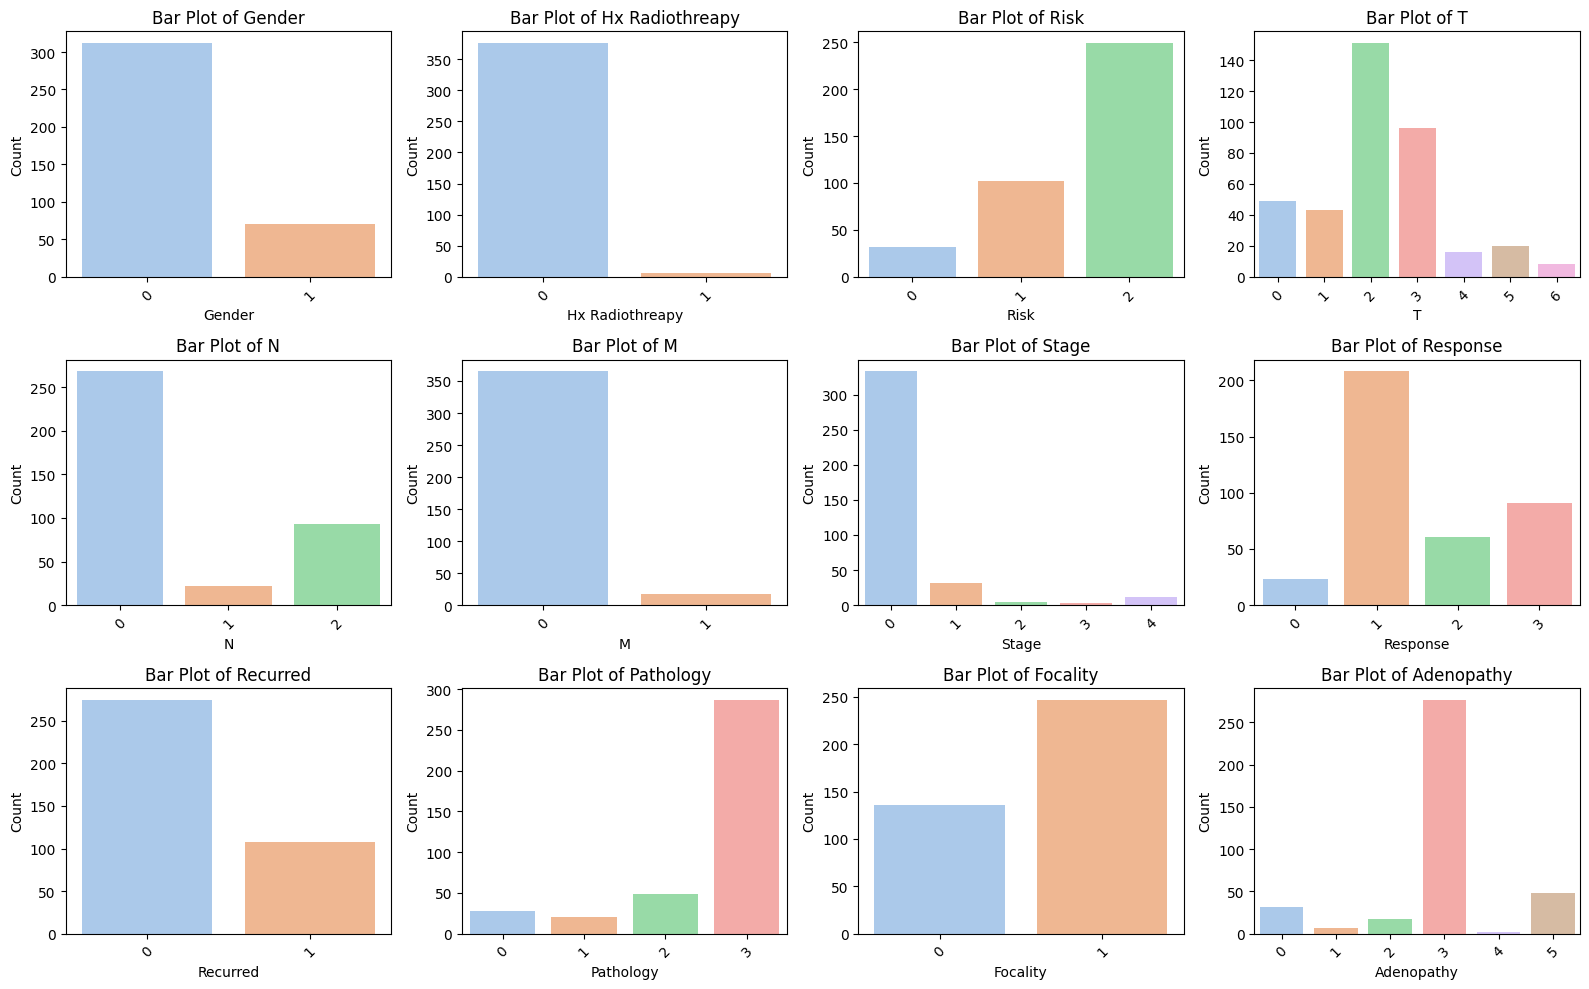

In [40]:
categorical = ['Gender', 'Hx Radiothreapy',
               'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred',
               'Pathology', 'Focality', 'Adenopathy']
# Determine number of variables
n = len(categorical)
# Set subplot layout (e.g., 3 rows, 4 columns)
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()  # Flatten in case of 2D array of axes

for i, var in enumerate(categorical):
    sns.countplot(x=df[var], ax=axes[i], palette="pastel")
    axes[i].set_title(f'Bar Plot of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Optional: Rotate labels for readability

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


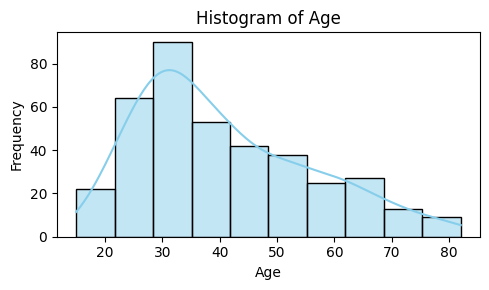

In [41]:
plt.figure(figsize=(5, 3))
sns.histplot(df['Age'], bins=10, kde=True, color='skyblue')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**TRAIN-TEST SPLIT**

In [42]:
x = df.drop("Recurred", axis=1)
y = df["Recurred"]
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

**XGBOOST MODEL**

In [43]:
# Define XGBoost model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
# Define SMOTE and XGBoost as a pipeline
smote_xgb_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('xgb', xgb_clf)
])
# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 8, 10],
    'xgb__learning_rate': [0.001, 0.01, 0.1]
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_xgb_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importa...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.001, 0.01, 0.1],
                         'xgb__max_depth': [3, 5, 8, 10],
                         'xgb__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [44]:
# Get best parameters for XGBOOST
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 8, 'xgb__n_estimators': 200}


In [45]:
# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Test Accuracy of XGBOOST:", accuracy)

Test Accuracy of XGBOOST: 0.935064935064935


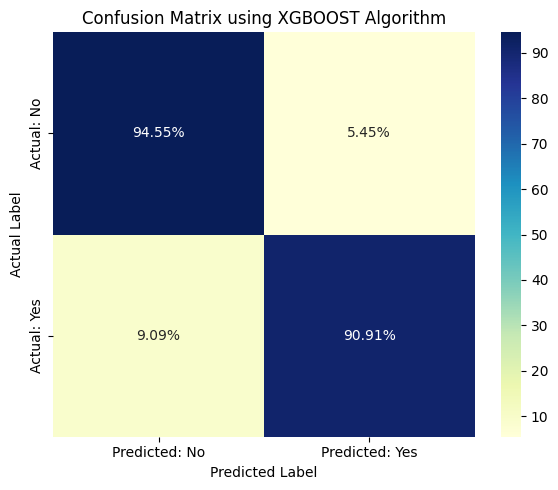

In [47]:
# Compute confusion matrix for XGBOOST
cm = confusion_matrix(y_test, y_pred_xgb)
# Row-wise percentage (normalize by actual class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a string with '%' symbol
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=["Predicted: No", "Predicted: Yes"],
            yticklabels=["Actual: No", "Actual: Yes"])
plt.title("Confusion Matrix using XGBOOST Algorithm")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [53]:
print("XGBOOST Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBOOST Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95        55
           1       0.87      0.91      0.89        22

    accuracy                           0.94        77
   macro avg       0.92      0.93      0.92        77
weighted avg       0.94      0.94      0.94        77



**RANDOM FOREST**

In [48]:
# Define Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
# Define SMOTE and Random Forest as a pipeline
smote_rf_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rf', rf_clf)
])
# Define hyperparameter grid
param_grid = {
    'rf__n_estimators': [100, 150, 200, 250],  # Number of trees
    'rf__max_depth': [3, 5, 8, 10, 15],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_rf_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5, 8, 10, 15],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=2)

In [49]:
# Get best parameters for Random Forest Algorithm
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'rf__max_depth': 8, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}


In [50]:
# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy for RF:", accuracy)

Test Accuracy for RF: 0.948051948051948


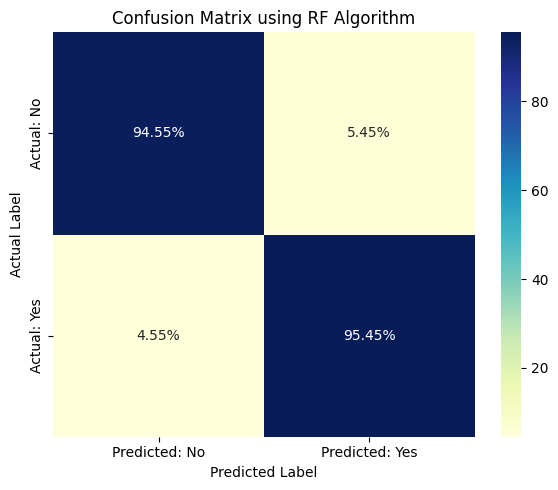

In [51]:
# Compute confusion matrix for Random Forest Classifier
cm = confusion_matrix(y_test, y_pred_rf)
# Row-wise percentage (normalize by actual class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a string with '%' symbol
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=["Predicted: No", "Predicted: Yes"],
            yticklabels=["Actual: No", "Actual: Yes"])
plt.title("Confusion Matrix using RF Algorithm")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [52]:
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.88      0.95      0.91        22

    accuracy                           0.95        77
   macro avg       0.93      0.95      0.94        77
weighted avg       0.95      0.95      0.95        77



**LIGHT-GBM**

In [54]:
# Define LightGBM model
lgb_clf = lgb.LGBMClassifier(random_state=42)
# Define SMOTE and LightGBM as a pipeline
smote_lgb_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('lgb', lgb_clf)
])
# Define hyperparameter grid
param_grid = {
    'lgb__n_estimators': [100, 200, 300],  # Number of trees
    'lgb__max_depth': [3, 5, 8, -1],  # Maximum tree depth (-1 means no limit)
    'lgb__learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'lgb__num_leaves': [20, 31, 40],  # Number of leaves in one tree
}
# Perform Grid Search with 10-fold CV
grid_search = GridSearchCV(smote_lgb_pipeline, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 220, number of negative: 220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 440, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('lgb',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgb__learning_rate': [0.001, 0.01, 0.1],
                         'lgb__max_depth': [3, 5, 8, -1],
                         'lgb__n_estimators': [100, 200, 300],
                         'lgb__num_leaves': [20, 31, 40]},
             scoring='accuracy', verbose=2)

In [55]:
# Get best parameters for LightGBM
print("Best Parameters for Light-GBM:", grid_search.best_params_)

Best Parameters for Light-GBM: {'lgb__learning_rate': 0.01, 'lgb__max_depth': 3, 'lgb__n_estimators': 300, 'lgb__num_leaves': 20}


In [56]:
# Evaluate on test set
best_lgb = grid_search.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lgb)
print("Test Accuracy for Light-GBM:", accuracy)

Test Accuracy for Light-GBM: 0.922077922077922


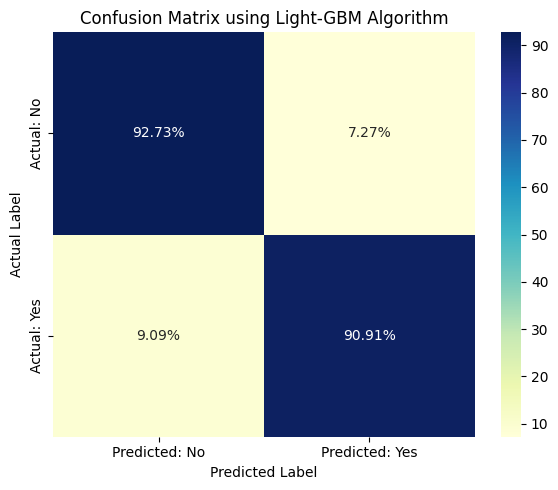

In [57]:
# Compute confusion matrix for Light GBM Classifier
cm = confusion_matrix(y_test, y_pred_lgb)
# Row-wise percentage (normalize by actual class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a string with '%' symbol
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=["Predicted: No", "Predicted: Yes"],
            yticklabels=["Actual: No", "Actual: Yes"])
plt.title("Confusion Matrix using Light-GBM Algorithm")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [58]:
print("Light-GBM Classification Report:\n", classification_report(y_test, y_pred_lgb))

Light-GBM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.83      0.91      0.87        22

    accuracy                           0.92        77
   macro avg       0.90      0.92      0.91        77
weighted avg       0.93      0.92      0.92        77



In [59]:
# Define individual models
xgb_clf = xgb.XGBClassifier(n_estimators=200, eval_metric="logloss", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
lgb_clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=31, random_state=42)
# Create an ensemble VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lgb', lgb_clf)],
    voting='soft'  # Soft voting to use probability estimates
)
# Train the ensemble model
ensemble_clf.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86, number of negative: 220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281046 -> initscore=-0.939280
[LightGBM] [Info] Start training from score -0.939280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('lgb',
                              LGBMClassifier(n_estimators=200,
                                             random_state=42))],
                 voting='soft')

In [60]:
# Predict on test set
y_pred_en = ensemble_clf.predict(X_test)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_en)
print("Ensemble Model Test Accuracy:", accuracy)

Ensemble Model Test Accuracy: 0.948051948051948


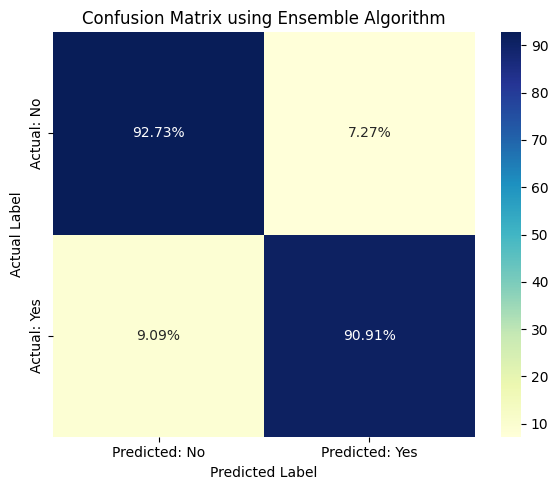

In [61]:
# Compute confusion matrix for Ensemble Classifier
cm = confusion_matrix(y_test, y_pred_lgb)
# Row-wise percentage (normalize by actual class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a string with '%' symbol
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=["Predicted: No", "Predicted: Yes"],
            yticklabels=["Actual: No", "Actual: Yes"])
plt.title("Confusion Matrix using Ensemble Algorithm")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [62]:
print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_en))

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.88      0.95      0.91        22

    accuracy                           0.95        77
   macro avg       0.93      0.95      0.94        77
weighted avg       0.95      0.95      0.95        77



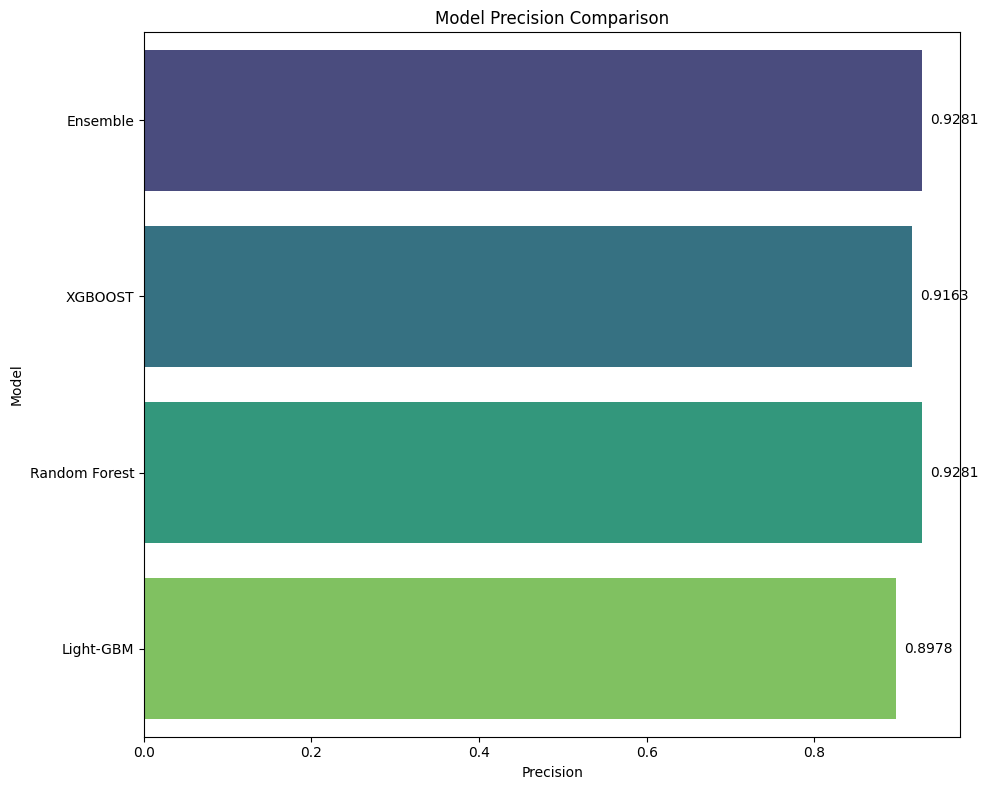

In [68]:
# Create a dictionary with model names and corresponding precision values
precision_dict = {
    'Ensemble': precision_score(y_test, y_pred_en, average='macro'),
    'XGBOOST': precision_score(y_test, y_pred_xgb, average='macro'),
    'Random Forest': precision_score(y_test, y_pred_rf, average='macro'),
    'Light-GBM': precision_score(y_test, y_pred_lgb, average='macro')
}
# Convert dictionary to DataFrame for easy plotting
precision_df = pd.DataFrame(list(precision_dict.items()), columns=['Model', 'Precision'])
# Create a barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='Precision', y='Model', data=precision_df, palette='viridis')
# Add the precision values on top of the bars
for index, value in enumerate(precision_df['Precision']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')
# Set labels and title
plt.xlabel('Precision')
plt.ylabel('Model')
plt.title('Model Precision Comparison')
# Show the plot
plt.tight_layout()
plt.show()

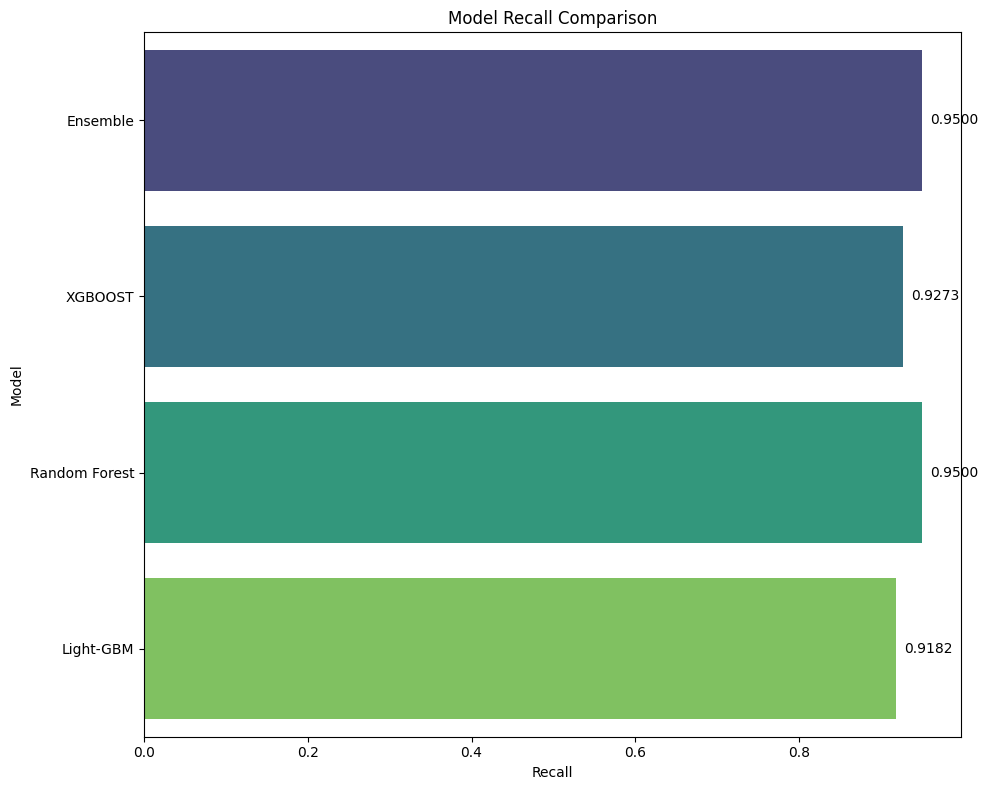

In [69]:
# Create a dictionary with model names and corresponding recall values
recall_dict = {
    'Ensemble': recall_score(y_test, y_pred_en, average='macro'),
    'XGBOOST': recall_score(y_test, y_pred_xgb, average='macro'),
    'Random Forest': recall_score(y_test, y_pred_rf, average='macro'),
    'Light-GBM': recall_score(y_test, y_pred_lgb, average='macro')
}
# Convert dictionary to DataFrame for easy plotting
recall_df = pd.DataFrame(list(recall_dict.items()), columns=['Model', 'Recall'])
# Create a barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='Recall', y='Model', data=recall_df, palette='viridis')
# Add the recall values on top of the bars
for index, value in enumerate(recall_df['Recall']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')
# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Model')
plt.title('Model Recall Comparison')
# Show the plot
plt.tight_layout()
plt.show()

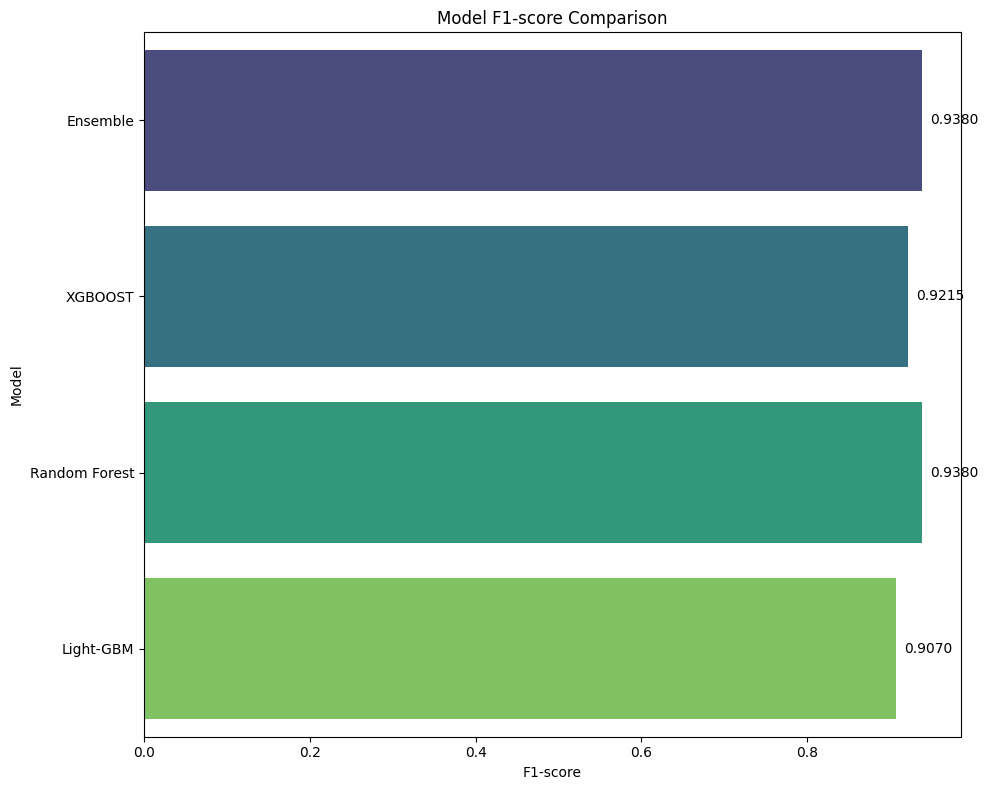

In [70]:
# Create a dictionary with model names and corresponding f1-score values
f1_score_dict = {
    'Ensemble': f1_score(y_test, y_pred_en, average='macro'),
    'XGBOOST': f1_score(y_test, y_pred_xgb, average='macro'),
    'Random Forest': f1_score(y_test, y_pred_rf, average='macro'),
    'Light-GBM': f1_score(y_test, y_pred_lgb, average='macro')
}
# Convert dictionary to DataFrame for easy plotting
f1_score_df = pd.DataFrame(list(f1_score_dict.items()), columns=['Model', 'F1-score'])
# Create a barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='F1-score', y='Model', data=f1_score_df, palette='viridis')
# Add the f1 values on top of the bars
for index, value in enumerate(f1_score_df['F1-score']):
    plt.text(value + 0.01, index, f'{value:.4f}', va='center')
# Set labels and title
plt.xlabel('F1-score')
plt.ylabel('Model')
plt.title('Model F1-score Comparison')
# Show the plot
plt.tight_layout()

In [72]:
# Ensemble Kappa Calculation
kappa_en = cohen_kappa_score(y_test, y_pred_en)
# XGBOOST Kappa Calculation
kappa_xg = cohen_kappa_score(y_test, y_pred_xgb)
# Random Forest Kappa Calculation
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
# LightGBM Kappa Calculation
kappa_lgb = cohen_kappa_score(y_test, y_pred_lgb)
# Display Kappa results
print(f"Kappa for Ensemble: {kappa_en:.4f}")
print(f"Kappa for XGBOOST: {kappa_xg:.4f}")
print(f"Kappa for RF: {kappa_rf:.4f}")
print(f"Kappa for LightGBM: {kappa_lgb:.4f}")

Kappa for Ensemble: 0.8761
Kappa for XGBOOST: 0.8430
Kappa for RF: 0.8761
Kappa for LightGBM: 0.8142
